

# A Numerical Solver for Burgers' Equation in 2 Dimensions 
An intro to our loss module's finite difference utility demonstrating
its use to create a simple numerical solver for Burgers' equation in 2d.


## Import the library
We first import our `neuralop` library and required dependencies.



In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from neuralop.losses.finite_diff import central_diff_2d  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Defining our problem
We aim to solve the 2D viscous Burger's equations:

:math: `u_t + u \cdot u_x + v \cdot u_y = \nu (u_xx + u_yy)`

:math: `v_t + u \cdot v_x + v \cdot v_y = \nu (v_xx + v_yy)`



In [2]:
## Simulation parameters
Lx, Ly = 2.0, 2.0   # Domain lengths
nx, ny = 64, 64   # Grid resolution
T = 1    # Total simulation time
dt = 0.001  # Time step
nu = 0.04   # Viscosity

## Create grid
X = torch.linspace(0, Lx, nx, device=device).repeat(ny, 1).T 
Y = torch.linspace(0, Ly, ny, device=device).repeat(nx, 1)  
dx = Lx / (nx-1)
dy = Ly / (ny-1)
nt = int(T / dt)

## Initial condition 
u = -torch.sin(2 * np.pi * Y).to(device)
v =  torch.cos(2 * np.pi * X).to(device)

## Simulate evolution using numerical solver



In [3]:
u_evolution = [u.clone()]
v_evolution = [v.clone()]

for _ in range(nt):
    
    # Compute first-order derivatives
    u_x, u_y = central_diff_2d(u, [dx, dy])
    v_x, v_y = central_diff_2d(v, [dx, dy])

    # Compute second-order derivatives
    u_xx, _ = central_diff_2d(u_x, [dx, dy])
    _, u_yy = central_diff_2d(u_y, [dx, dy])
    v_xx, _ = central_diff_2d(v_x, [dx, dy])
    _, v_yy = central_diff_2d(v_y, [dx, dy])

    # Evolve in time using Euler's method
    u_next = u + dt * (-u * u_x - v * u_y + nu * (u_xx + u_yy))
    v_next = v + dt * (-u * v_x - v * v_y + nu * (v_xx + v_yy))
    
    u, v = u_next.clone(), v_next.clone()
    u_evolution.append(u.clone())
    v_evolution.append(v.clone())

u_evolution = torch.stack(u_evolution).cpu().numpy()
v_evolution = torch.stack(v_evolution).cpu().numpy()

## Animating the solution



MovieWriter Pillow unavailable; using Pillow instead.


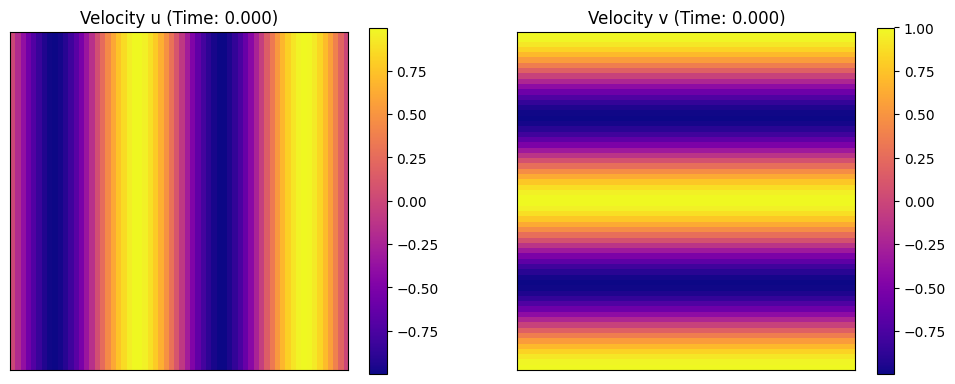

In [6]:
num_frames = 100
frame_indices = torch.linspace(0, len(u_evolution) - 1, num_frames, dtype=torch.int).cpu().numpy()
u_frames = u_evolution[frame_indices]
v_frames = v_evolution[frame_indices]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
cmap_u = axs[0].imshow(u_frames[0], extent=[0, Lx, 0, Ly], origin="lower", cmap="plasma")
axs[0].set_title("Velocity u")
plt.colorbar(cmap_u, ax=axs[0], shrink=0.75) 
cmap_v = axs[1].imshow(v_frames[0], extent=[0, Lx, 0, Ly], origin="lower", cmap="plasma")
axs[1].set_title("Velocity v")
plt.colorbar(cmap_v, ax=axs[1], shrink=0.75) 

def update(frame):
    cmap_u.set_data(u_frames[frame])
    cmap_v.set_data(v_frames[frame])
    axs[0].set_title(f"Velocity u (Time: {frame_indices[frame] * dt:.3f})")
    axs[1].set_title(f"Velocity v (Time: {frame_indices[frame] * dt:.3f})")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    return cmap_u, cmap_v

ani = animation.FuncAnimation(fig, update, frames=len(u_frames), interval=50, blit=False)
ani.save("burfers_2d.gif", writer="Pillow", fps=30)